In [10]:
# Import necessary libraries
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np


import torch
import timm  # Library for pre-trained ViT models
import torch.nn as nn
import torch.nn.functional as F

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cuda


In [ ]:
# Define transformations for training and testing datasets (converting from 32x32 to 224x224)
transform = transforms.Compose([
    transforms.Resize((224, 224), interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])


# Load CIFAR-100 dataset
train_dataset = datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)

100%|██████████| 169M/169M [00:13<00:00, 12.8MB/s] 


Extracting ./data\cifar-100-python.tar.gz to ./data
Files already downloaded and verified


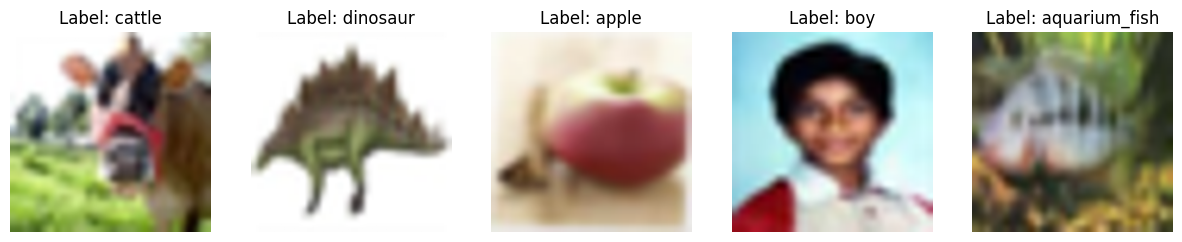

In [3]:
# Function to unnormalize images for visualization
def unnormalize(img):
    img = img * 0.5 + 0.5  # Unnormalize
    return img

# Display a few sample images
classes = train_dataset.classes
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    img, label = train_dataset[i]
    img = unnormalize(img).permute(1, 2, 0).numpy()
    axes[i].imshow(img)
    axes[i].set_title(f"Label: {classes[label]}")
    axes[i].axis('off')
plt.show()


In [8]:

# Check a sample batch shape
for images, labels in train_loader:
    print(f"Batch shape: {images.shape}")
    print(f"Labels shape: {labels.shape}")
    break


Batch shape: torch.Size([64, 3, 224, 224])
Labels shape: torch.Size([64])


### VIT TEACHER MODEL

In [9]:
# Load pre-trained ViT-Small model from timm
vit_model = timm.create_model('vit_small_patch16_224', pretrained=True)
vit_model.to(device)
vit_model.eval()  # Set to evaluation mode

# Print model architecture (optional)
print(vit_model)


c:\Users\csury\anaconda3\envs\att_distill\lib\site-packages\huggingface_hub\file_download.py:142: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\csury\.cache\huggingface\hub\models--timm--vit_small_patch16_224.augreg_in21k_ft_in1k. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity(

In [11]:
# Function to extract attention maps using hooks
def get_attention_maps(model, x):
    attention_maps = []

    # Define a hook to capture attention maps
    def hook(module, input, output):
        # Extract only attention weights (not key or query values)
        attention_maps.append(output)

    # Register hooks on all attention layers
    handles = [layer.attn.register_forward_hook(hook) for layer in model.blocks]

    # Forward pass to extract attention maps
    with torch.no_grad():
        _ = model(x)

    # Remove hooks after extraction
    for handle in handles:
        handle.remove()

    return attention_maps


In [12]:
# Function to compute entropy for attention maps
def compute_entropy(attention_map):
    epsilon = 1e-10  # Small value to avoid log(0)
    # Flatten the map and compute probabilities
    attention_map = attention_map.view(attention_map.size(0), -1)  # Flatten spatial dimensions
    attention_map = F.softmax(attention_map, dim=-1)  # Convert to probabilities
    # Compute entropy
    entropy = -torch.sum(attention_map * torch.log(attention_map + epsilon), dim=-1)
    return entropy.mean().item()  # Return average entropy

In [13]:
# Function to compute dynamic layer weights based on entropy (assigning higher weight to lower entropy layers)
def get_layer_weights(attention_maps):
    entropies = [compute_entropy(attn) for attn in attention_maps]
    total_entropy = sum(entropies)
    # Compute weights inversely proportional to entropy
    layer_weights = [(total_entropy - ent) / total_entropy for ent in entropies]
    return layer_weights


In [14]:
# Get a sample batch from train_loader
images, labels = next(iter(train_loader))
images = images.to(device)

# Extract attention maps
attention_maps = get_attention_maps(vit_model, images)
print(f"Extracted {len(attention_maps)} attention maps")

# Compute dynamic weights based on entropy
layer_weights = get_layer_weights(attention_maps)
print(f"Layer Weights: {layer_weights}")


Extracted 12 attention maps
Layer Weights: [0.9116814550432623, 0.9122360035554378, 0.9113638554906974, 0.9114475562139969, 0.9114712609490881, 0.911319223682641, 0.9115418150807996, 0.9116072755705199, 0.9117859844482255, 0.9124511323518084, 0.9145121652178257, 0.9685822723956975]


In [20]:
# Visualize a sample attention map
def visualize_attention_map(attention_map):
    # Select the first image's first head attention map for visualization
    # Expected shape: (batch_size, num_heads, num_patches, num_patches)
    # Select first batch and first head
    attention_map = attention_map[0, 0].detach().cpu().numpy()
    
    # Check if the attention map needs reshaping
    if attention_map.shape[0] == 196 and attention_map.shape[1] == 196:
        print("Attention map shape:", attention_map.shape)
        plt.imshow(attention_map, cmap='viridis')
        plt.colorbar()
        plt.title("Sample Attention Map (14x14 Patches)")
        plt.show()
    else:
        print(f"Unexpected attention map shape: {attention_map.shape}")

# Visualize attention map of the first layer
visualize_attention_map(attention_maps[0])



Unexpected attention map shape: (384,)
